# Word Co-occurrence Analysis

On this notebook I will work my way through a co-occurrence analysis with python and scikit. By the end, our result will be a graph depicting word relationships based on document co-occurrence.

The dataset contains 12,435 medical package insert documents.  This is a private dataset, so I won't be able to make it available, but the technique can be replicated with your own corpus without a lot of modification.

In [1]:
import pandas as pd
import morph
import csv

## Load the Data

Since this data set is in Japanese, the text pre-processing that takes place is a little different than usual. There is no need to perform (explicit) stemming or lemmatization. Converting to lowercase does not make sense either.  However, the tokenization process is more difficult, since Japanese words aren't separated by spaces. I am using [MeCab](http://taku910.github.io/mecab/) in order to perform text segmentation and extract only the Parts of Speech we're interested in. The method "mecabify" is included in "morph".

The original data is composed of 8 columns. The first two are the document id and the group it belongs to. We don't need these for our analysis. The rest contain information like side-effects, intake, special considerations during pregnancy, etc. 

Word co-ccurence can be interpeted as a measure of similarity. However, the co-occurrence term is not strictly defined. We can prepare word frequency matrices depending on their appeareance on sentences, paragraphs or whole documents. We will work at the sentence  scope.

In [2]:
data = pd.read_csv("data/bunsho.csv", delimiter=',', na_filter=False)
documents = []
for i,row in data.iterrows():
    if(i%1000 == 0):
        print "Analyzed: " + str(i) + "/" + str(len(data)) + " items."
    for x in range(2,8):
        if row[x] != "":
            for sentence in row[x].split('。'):
                documents.append(morph.mecabify(sentence,False,False))

Analyzed: 0/12435 items.
Analyzed: 1000/12435 items.
Analyzed: 2000/12435 items.
Analyzed: 3000/12435 items.
Analyzed: 4000/12435 items.
Analyzed: 5000/12435 items.
Analyzed: 6000/12435 items.
Analyzed: 7000/12435 items.
Analyzed: 8000/12435 items.
Analyzed: 9000/12435 items.
Analyzed: 10000/12435 items.
Analyzed: 11000/12435 items.
Analyzed: 12000/12435 items.


We end up with this many documents in our corpus:

In [32]:
print "corpus size: " , len(documents)

corpus size:  594815


In [33]:
for doc in documents[2000:2005]:
    print doc

次 副作用 症状 適切処置
譫妄 精神神経 頻度不明激越
循環器 頻度不明不整脈 血圧変動 ＳＴ低下 心電図異常 徐脈 脈
機能異常 ＡＬＴ上昇 肝臓 ＡＳＴ上昇 ＧＰＴ上昇 ＧＯＴ上昇 頻度不明
嘔吐 消化器 頻度不明悪心


There is some noise due to the document format (the first sentence), however, some sentences accurately depict the relationship between words. For example: 
機能異常 ＡＬＴ上昇 肝臓 ＡＳＴ上昇 ＧＰＴ上昇 ＧＯＴ上昇 頻度不明  where an abnormal function of the liver can lead to increased ALT, AST, etc. levels.

## Word count

To begin, we will count how many times a word appears per document, effectively building a document-term-matrix. [Wikipedia](https://en.wikipedia.org/wiki/Document-term_matrix) defines a dtm as a mathematical matrix that describes the frequency of terms that occur in a collection of documents. Rows correspond to documents in the collection, and columns correspond to terms.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy

Stop words are words which are filtered out before or after processing of natural language data (text). The term usually refers to the most common words in a language, but there is no single universal list of stop words used by all natural language processing tools. For this analysis I used a list of japanese stopwords and extended it with some words that made no sense for my application (Like some specific proper nouns). Indeed, the list of stopwords depends on what you want to achieve, but the list of english stopwords from nltk is very commonly used.

In [35]:
stopwordsFilename = "data/stopwords.txt"
stopwords  = pd.read_csv(stopwordsFilename, delimiter=',', na_filter=False)["stopwords"]

The function below is the custom [tokenizer](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) we pass to CountVectorizer. In our case, MeCab already did all the work, so we will only use it to remove stopwords.

We could've passed the mecabify function here as well, but I preferred to have it separatedly in order to:

- Control the document definition (Sentences)
- Save the pre-processed corpus

The last item intends to reduce the time used for the mecab analysis, for example, when new stopwords are added, there is no need to re-split sentences into space separated words.



In [55]:
def space_break(text):
    words  = text.split()
    for w in words:
        if w not in stopwords:
            yield w

Count Vectorizer will take the corpus as input and output a dtm. max_df and min_df allow us to ignore words that appear in too many documents (think of it as a low variance feature) or in too few ones (think of a variable that is unique to a sample, such as an ID).

In [56]:
vectorizer = CountVectorizer(max_df=0.75, min_df=5, analyzer = space_break, stop_words = stopwords,lowercase=False)
dtm = vectorizer.fit_transform(documents)
features = vectorizer.get_feature_names()

In [57]:
dtm.shape

(594815, 24840)

The dtm matrix contains 594815 rows. One for each document in the corpus.<br/>
It also has 24840 columns, corresponding to all the extracted words.<br/> 
The number in the position X[i,j] represents how many times a word appears in a document. As you might've guessed, most of the matrix values are actually zero, and this is known as a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix).  A sparse matrix can be represented as a dictionary of coordinates and values to save space in memory. It can be coerced into a dense matrix, but depending on its dimensions, it might cause memory problems.

Finally, the features list contains all the extracted words. This can be used as an index of the X matrix columns. 

In [58]:
for x in features[12000:12010]: print x

感染
感染ボランティア
感染リスク
感染予防
感染初期
感染巣
感染性
感染性ぶどう膜炎
感染性ショック
感染性下痢患者


### Creating a Co-occurence Matrix

To create a co-occurence matrix, in which both rows and columns are the extracted words and the i,j intersection represents in how many documents they appear together, we simply mulitply the dtm Matrix by its transpose. 

In [59]:
cooc = (dtm.T * dtm)
cooc.shape

(24840, 24840)

## Word Similarity Measures

Working on the explanation of the below steps :)

In [64]:
term = "エイズ"

#Corpus Size (Scalar)
k = (dtm.shape[0])

#Term count (Scalar)
ki = dtm[:,features.index(term)].sum()  #Equivalent to cooc[features.index(term),features.index(term)]

#Every Term Count (Vector)
kj = cooc.diagonal()   #Equivalent to dtm.sum(axis=0)

#Term co-occurence counts
kij = cooc[features.index(term), ]

In [65]:
dicesig = 2 * kij / (ki + kj)

In [66]:
import numpy as np
scores = pd.Series(np.squeeze(np.asarray(dicesig)), index = features)

In [67]:
scores.sort_values(ascending=False).head(15)

エイズ                          1.000000
後天性免疫不全症候群                   0.916667
播種性ＭＡＣ症                      0.517241
ＭＡＣ                          0.359338
播種性マイコバクテリウム・アビウムコンプレックス     0.340102
臨床的細菌学的改善                    0.299320
偏執反応                         0.255034
神経過敏症                        0.246753
膣トリコモナス症                     0.201439
播種性マイコバクテリウム・アビウムコンプレックス症    0.201439
淋病                           0.201439
性感染症                         0.194444
クラミジア感染症                     0.187919
圭コンジローマ                      0.178344
頻度不明不眠症                      0.173913
dtype: float64

## Visualization

In [69]:
import networkx as nx
%matplotlib inline

In [70]:
def dicesig(k,ki,kj,kij):
    return 2 * kij / (ki + kj)

In [72]:
def get_distances(term, num_terms, metric):

    term_index = features.index(term)
    k = (dtm.shape[0])
    ki = cooc[term_index,term_index]
    kj = dtm.diagonal() 
    kij = cooc[term_index, ]
    
    scores = metric(k,ki,kj,kij)
    scores = pd.Series(np.squeeze(np.asarray(scores)), index = features)
    scores = scores.sort_values(ascending=False).head(num_terms)
    return scores

In [73]:
def expand_term(term, num_terms, depth, metric):
    distances = {}
    pending = [term]
    for _ in range(depth):
        queue = pending
        for current_term in queue:
            pending.remove(current_term)
            if current_term not in distances:
                distances[current_term] = get_distances(current_term, num_terms,metric)
                pending = pending + list(distances.get(current_term).index)
    return distances

In [15]:
#def plot_graph(edge_list):

In [74]:
def buid_dist_matrix(term, num_terms, depth, metric):
    all_terms = expand_term(term, num_terms,depth,metric)
    rel_mat = pd.DataFrame(0, index=all_terms.keys(), columns=all_terms.keys())
    for term, distances in all_terms.items():
        indexer = list(set(distances.index).intersection(set(rel_mat.index)))
        rel_mat.loc[term,indexer] = distances[indexer]
        
    return rel_mat

In [75]:
buid_dist_matrix("エイズ",5,3,dicesig).iloc[0:5,0:5]

,ＭＡＣ,症,後天性免疫不全症候群,発疹,湿疹
ＭＡＣ,2.000000,1.879195,0.510067,0.000000,0.000000
症,0.000000,2.000000,0.000000,0.482012,0.479691
後天性免疫不全症候群,1.321739,1.321739,2.000000,0.000000,0.000000
発疹,0.000000,0.000000,0.000000,2.000000,0.000000
湿疹,0.000000,0.734597,0.000000,0.000000,2.000000


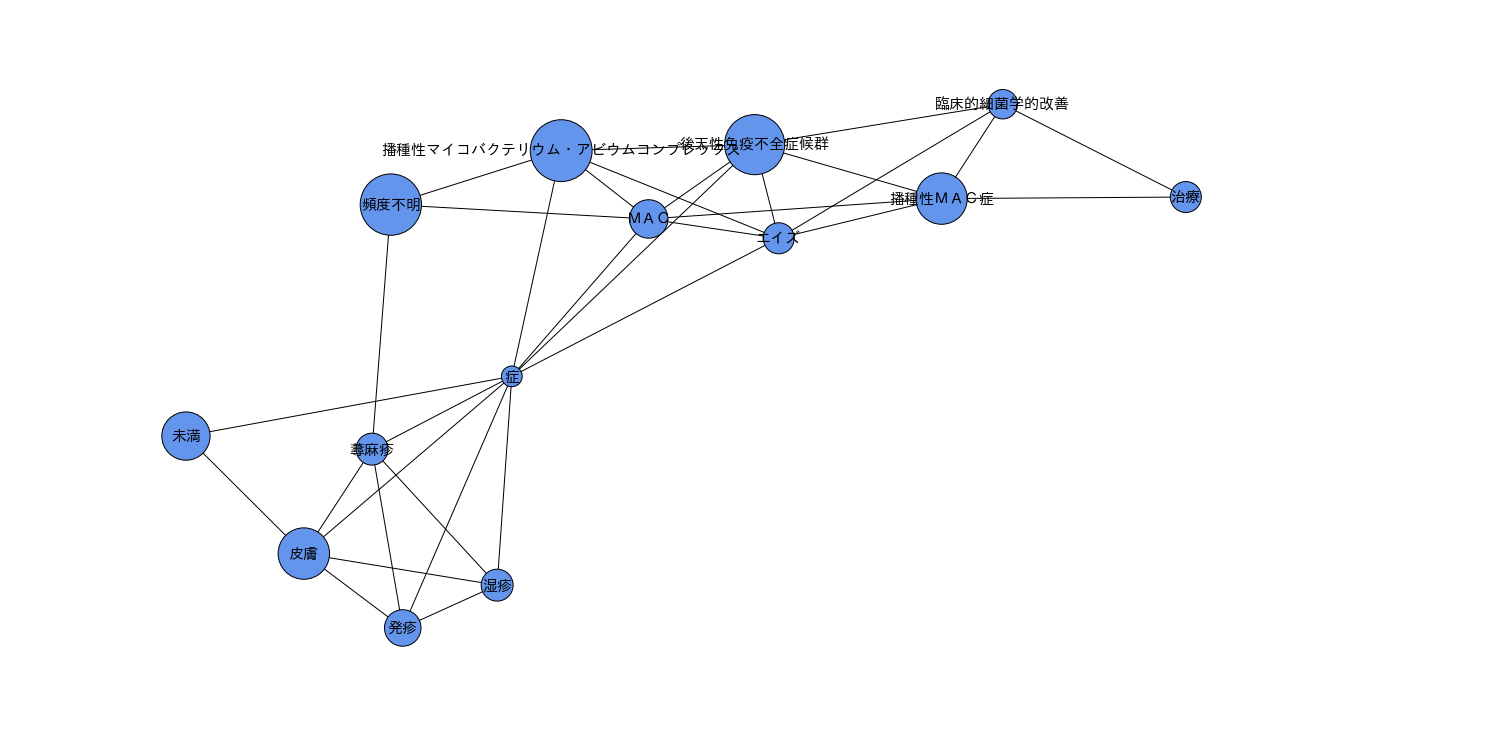

In [77]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Transform it in a links data frame (3 columns only):
links = buid_dist_matrix("エイズ", 6,3,dicesig).stack().reset_index()
links.columns = ['var1', 'var2','value']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.2) & (links['var1'] != links['var2']) ]
links_filtered.is_copy = False
links_filtered["var1"] = links_filtered["var1"].apply(lambda x: x.decode('utf8'))
links_filtered["var2"] = links_filtered["var2"].apply(lambda x: x.decode('utf8'))

G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')


plt.figure(figsize=(20,10))
# Plot the network:
np.random.seed(2)
nx.draw(G, with_labels=True, node_color='cornflowerblue', node_size=links_filtered["value"]*2000, edge_color='black', linewidths=1, font_size=15, font_family="IPAexGothic")